#### Copyright (c) 2025 Graphcore Ltd. All rights reserved.

In [1]:
import json
import os.path as osp
import pickle
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plot_utils
import scipy as sp
import seaborn as sns
from tqdm import tqdm

plot_utils.configure()

/nethome/albertoc/research/knowledge_graphs/synth-kgqa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra
Couldn't find font 'CMU Serif'.
On Ubuntu:
  sudo apt install fonts-cmu
  rm ~/.cache/matplotlib/fontlist-*.json
  (restart kernel)
  (original error: ValueError('Failed to find font CMU Serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.400000000000002, and fallback to the default font was disabled'))


## Load data

In [2]:
kg_path = "../data/ogbl_wikikg2"

node_labels = np.load(
    osp.join(kg_path, "node_labels.npy"),
    allow_pickle=True,
)
node_qids = np.load(
    osp.join(kg_path, "node_ids.npy"),
    allow_pickle=True,
)
relation_labels = np.load(
    osp.join(kg_path, "relation_labels.npy"),
    allow_pickle=True,
)
relation_pids = np.load(
    osp.join(kg_path, "relation_ids.npy"),
    allow_pickle=True,
)
edge_ids = np.load(osp.join(kg_path, "edge_ids.npy"))
relation_types = np.load(osp.join(kg_path, "relation_types.npy"))

rev_lkp_ent = {ent: idx for idx, ent in enumerate(node_qids)}
rev_lkp_rel = {rel: idx for idx, rel in enumerate(relation_pids)}

In [3]:
gtsqa = load_dataset("Graphcore/GTSQA")
train_ds = gtsqa["train"]
test_ds = gtsqa["test"]

id_to_i = {dp["id"]: i for i, dp in enumerate(test_ds)}

len(train_ds), len(test_ds)

(30477, 1622)

## GTSQA Statistics

In [8]:
stats = []
for split, data in [["train", train_ds], ["test", test_ds]]:
    for dp in data:
        stats.append(
            {
                "id": dp["id"],
                "graph_template": dp["graph_isomorphism"],
                "minimal_graph_template": dp["minimal_graph_isomorphism"],
                "n_seed_nodes": len(dp["seed_entities"]),
                "n_hops": dp["n_hops"],
                "n_answers": len(dp["all_answers_wikidata"]),
                "n_gt_edges": len(dp["answer_subgraph"]),
                "n_full_edges": len(dp["full_answer_subgraph_wikidata"]),
                "test_type": dp["test_type"],
                "redundant": dp["redundant"],
                "split": split,
            }
        )

df = pd.DataFrame(stats)

In [9]:
# Table 1

all_stats = pd.DataFrame(
    {
        "statistic": [
            "# questions",
            "# relation types",
            "# unique entities",
            "# unique graph isomorphisms",
            "avg # seed nodes",
            "avg # hops",
            "avg # answers",
            "avg # ground-truth edges",
            "# questions with redundant info",
        ],
        "train": [
            len(train_ds),
            200,
            64435,
            df.query("split == 'train'").graph_template.unique().shape[0],
            df.query("split == 'train'").n_seed_nodes.mean().item(),
            df.query("split == 'train'").n_hops.mean().item(),
            df.query("split == 'train'").n_answers.mean().item(),
            df.query("split == 'train'").n_gt_edges.mean().item(),
            df.query("split == 'train'").redundant.sum().item(),
        ],
        "test": [
            len(test_ds),
            362,
            5665,
            df.query("split == 'test'").graph_template.unique().shape[0],
            df.query("split == 'test'").n_seed_nodes.mean().item(),
            df.query("split == 'test'").n_hops.mean().item(),
            df.query("split == 'test'").n_answers.mean().item(),
            df.query("split == 'test'").n_gt_edges.mean().item(),
            df.query("split == 'test'").redundant.sum().item(),
        ],
        "all": [
            len(test_ds) + len(train_ds),
            368,
            68520,
            df.graph_template.unique().shape[0],
            df.n_seed_nodes.mean().item(),
            df.n_hops.mean().item(),
            df.n_answers.mean().item(),
            df.n_gt_edges.mean().item(),
            df.redundant.sum().item(),
        ],
    }
)
all_stats

,statistic,train,test,all
0,# questions,30477.000000,1622.000000,32099.000000
1,# relation types,200.000000,362.000000,368.000000
2,# unique entities,64435.000000,5665.000000,68520.000000
3,# unique graph isomorphisms,19.000000,14.000000,27.000000
4,avg # seed nodes,1.649244,1.922318,1.663042
5,avg # hops,1.475539,2.017879,1.502944
6,avg # answers,1.540801,1.276202,1.527431
7,avg # ground-truth edges,2.168849,3.037608,2.212748
8,# questions with redundant info,7852.000000,0.000000,7852.000000


### Minimal graph isomorphism types

In [10]:
cts = (
    df.query("split == 'train'").groupby("graph_template", as_index=False)["id"].count()
)
cts["graph_templ_id"] = cts.apply(lambda x: x["graph_template"], axis=1)
cts["keep"] = cts["id"] >= 150
cts_min = (
    df.query("split == 'train'")
    .groupby("minimal_graph_template", as_index=False)["id"]
    .count()
)
cts_min["keep"] = cts_min["id"] >= 150

In [11]:
cts_fin = pd.concat(
    [
        cts.query("keep"),
        pd.DataFrame(
            {
                "graph_templ_id": ["other"],
                "id": [cts.query("~keep").id.sum()],
                "keep": [True],
            }
        ),
    ],
    axis=0,
)
cts_fin["frequency"] = cts_fin["id"] / cts_fin["id"].sum()
cts_fin = cts_fin.sort_values("frequency", ascending=False)
cts_fin["GT answer subgraph"] = "Complete"

cts_fin_min = pd.concat(
    [
        cts_min.query("keep").rename(
            columns={"minimal_graph_template": "graph_templ_id"}
        ),
        pd.DataFrame(
            {
                "graph_templ_id": ["other"],
                "id": [cts_min.query("~keep").id.sum()],
                "keep": [True],
            }
        ),
    ],
    axis=0,
)
cts_fin_min["frequency"] = cts_fin_min["id"] / cts_fin_min["id"].sum()
cts_fin_min["GT answer subgraph"] = "Minimal"

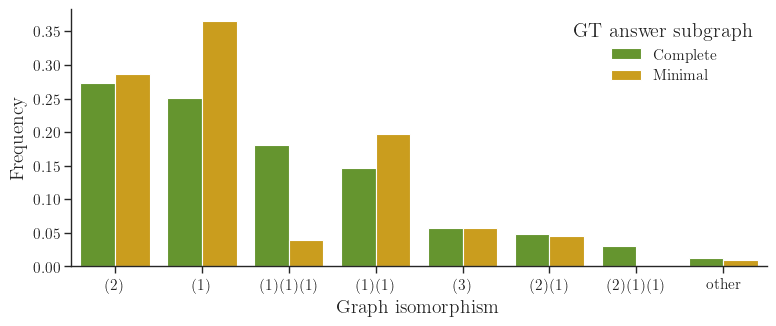

In [12]:
fig, ax = plt.subplots(figsize=(8, 3.5))

sns.barplot(
    data=pd.concat([cts_fin, cts_fin_min]),
    x="graph_templ_id",
    y="frequency",
    hue="GT answer subgraph",
    ax=ax,
    palette=[plot_utils.PALETTE[4], plot_utils.PALETTE[5]],
)

ax.set_xlabel("Graph isomorphism")
ax.set_ylabel("Frequency")
plot_utils.tidy(ax.figure)

### Distribution of graph isomorphisms

In [13]:
# Table A1

dfe = df.explode("test_type")

train_ct = (
    dfe.query("split=='train'").groupby("graph_template", as_index=False)["id"].count()
)
test_iid_ct = (
    dfe.query("split=='test' and test_type=='in_distribution'")
    .groupby("graph_template", as_index=False)["id"]
    .count()
)
test_unseen_graph_ct = (
    dfe.query("split=='test' and test_type=='unseen_graph_type'")
    .groupby("graph_template", as_index=False)["id"]
    .count()
)
test_unseen_relation_ct = (
    dfe.query("split=='test' and test_type=='unseen_relation_type'")
    .groupby("graph_template", as_index=False)["id"]
    .count()
)

count_res = pd.merge(
    train_ct,
    test_iid_ct,
    on="graph_template",
    suffixes=["train", "test_iid"],
    how="left",
).fillna(0)
count_res = pd.merge(
    count_res,
    test_unseen_graph_ct,
    on="graph_template",
    suffixes=["", "test_unseen_graph"],
    how="outer",
).fillna(0)
count_res = pd.merge(
    count_res,
    test_unseen_relation_ct,
    on="graph_template",
    suffixes=["", "test_unseen_relation"],
    how="left",
).fillna(0)
count_res = count_res.sort_values("graph_template")

count_res["idtest_unseen_relation"] = count_res.apply(
    lambda x: x["idtest_unseen_relation"] if x["id"] == 0 else 0, axis=1
)

count_res["idtrain_perc"] = round(100 * count_res["idtrain"] / len(train_ds), 2)
count_res["idtest_unseen_relation_perc"] = round(
    100 * count_res["idtest_unseen_relation"] / len(test_ds), 2
)
count_res["id_perc"] = round(100 * count_res["id"] / len(test_ds), 2)
count_res["idtest_iid_perc"] = round(100 * count_res["idtest_iid"] / len(test_ds), 2)
count_res.head()

,graph_template,idtrain,idtest_iid,id,idtest_unseen_relation,idtrain_perc,idtest_unseen_relation_perc,id_perc,idtest_iid_perc
0,((1)(1)(1)),144.0,0.0,0.0,0.0,0.47,0.0,0.00,0.0
1,((1)(1)(1))(1),18.0,0.0,0.0,0.0,0.06,0.0,0.00,0.0
2,((1)(1)(1))(2),1.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,((1)(1)),0.0,0.0,125.0,0.0,0.00,0.0,7.71,0.0
4,((1)(1))(1),0.0,0.0,60.0,0.0,0.00,0.0,3.70,0.0


### Distribution of n_hops, n_seeds_ n_answers, ...

/tmp/ipykernel_40521/2993949747.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8+"])


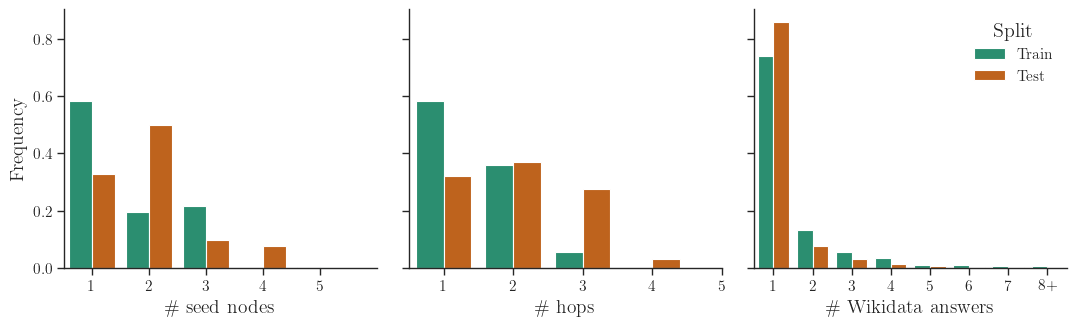

In [14]:
_, (ax0, ax2, ax1) = plt.subplots(1, 3, figsize=(11, 3.5), sharey=True)

to_plot = "n_seed_nodes"

counts = df.groupby(["split", to_plot], as_index=False)["id"].count()
counts["Split"] = counts.apply(lambda x: str.capitalize(x["split"]), axis=1)
counts["id"] /= counts.groupby("split")["id"].transform("sum")

sns.barplot(
    x=counts[to_plot],
    y=counts.id,
    hue=counts.split,
    hue_order=["train", "test"],
    ax=ax0,
)
ax0.set_xlabel("\# seed nodes")
ax0.set_ylabel("Frequency")
ax0.set_xlim([-0.5, 5])

to_plot = "n_hops"

counts = df.groupby(["split", to_plot], as_index=False)["id"].count()
counts["Split"] = counts.apply(lambda x: str.capitalize(x["split"]), axis=1)
counts["id"] /= counts.groupby("Split")["id"].transform("sum")

sns.barplot(
    x=counts[to_plot],
    y=counts.id,
    hue=counts.Split,
    hue_order=["Train", "Test"],
    ax=ax2,
)
ax2.set_xlabel("\# hops")
ax2.set_xlim([-0.5, 4])
ax2.legend_.remove()


df["n_answers_capped"] = df.n_answers.apply(lambda x: min(8, x))
to_plot = "n_answers_capped"

counts = df.groupby(["split", to_plot], as_index=False)["id"].count()
counts["Split"] = counts.apply(lambda x: str.capitalize(x["split"]), axis=1)
counts["id"] /= counts.groupby("split")["id"].transform("sum")

sns.barplot(
    x=counts[to_plot],
    y=counts.id,
    hue=counts.Split,
    hue_order=["Train", "Test"],
    ax=ax1,
)
ax1.set_xlabel("\# Wikidata answers")
ax1.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8+"])

ax0.legend_.remove()
plot_utils.tidy(ax0.figure)

/tmp/ipykernel_40521/3127039895.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(


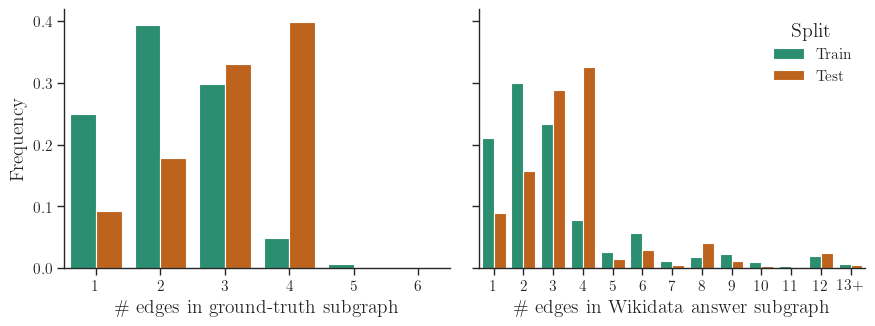

In [15]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)

to_plot = "n_gt_edges"

counts = df.groupby(["split", to_plot], as_index=False)["id"].count()
counts["Split"] = counts.apply(lambda x: str.capitalize(x["split"]), axis=1)
counts["id"] /= counts.groupby("split")["id"].transform("sum")

sns.barplot(
    x=counts[to_plot],
    y=counts.id,
    hue=counts.Split,
    hue_order=["Train", "Test"],
    ax=ax0,
)
ax0.set_xlabel("\# edges in ground-truth subgraph")
ax0.set_ylabel("Frequency")


df["n_full_edges_capped"] = df.n_full_edges.apply(lambda x: min(13, x))
to_plot = "n_full_edges_capped"

counts = df.groupby(["split", to_plot], as_index=False)["id"].count()
counts["Split"] = counts.apply(lambda x: str.capitalize(x["split"]), axis=1)
counts["id"] /= counts.groupby("split")["id"].transform("sum")

sns.barplot(
    x=counts[to_plot],
    y=counts.id,
    hue=counts.Split,
    hue_order=["Train", "Test"],
    ax=ax1,
)
ax1.set_xlabel("\# edges in Wikidata answer subgraph")
ax1.set_xticklabels(
    ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13+"]
)

ax0.legend_.remove()
plot_utils.tidy(ax0.figure)

### Distribution of relation types

In [16]:
all_rels_train = []
all_rels_test = []
for t in train_ds:
    all_rels_train.extend(
        [int(re.findall(r"\(P([0-9]+)\)-", trip)[0]) for trip in t["answer_subgraph"]]
    )
for t in test_ds:
    all_rels_test.extend(
        [int(re.findall(r"\(P([0-9]+)\)-", trip)[0]) for trip in t["answer_subgraph"]]
    )

In [17]:
unique_r, count_r = np.unique(all_rels_train, return_counts=True)
train_df = pd.DataFrame(
    {"rel_id": unique_r[np.argsort(count_r)], "rel_freq": count_r[np.argsort(count_r)]}
)
unique_r, count_r = np.unique(all_rels_test, return_counts=True)
test_df = pd.DataFrame(
    {"rel_id": unique_r[np.argsort(count_r)], "rel_freq": count_r[np.argsort(count_r)]}
)

to_plot_df = pd.merge(
    train_df, test_df, on="rel_id", how="outer", suffixes=["_train", "_test"]
).fillna(0)
to_plot_df["freq_tot"] = to_plot_df["rel_freq_test"] + to_plot_df["rel_freq_train"]
to_plot_df = to_plot_df.sort_values("freq_tot", ascending=False)

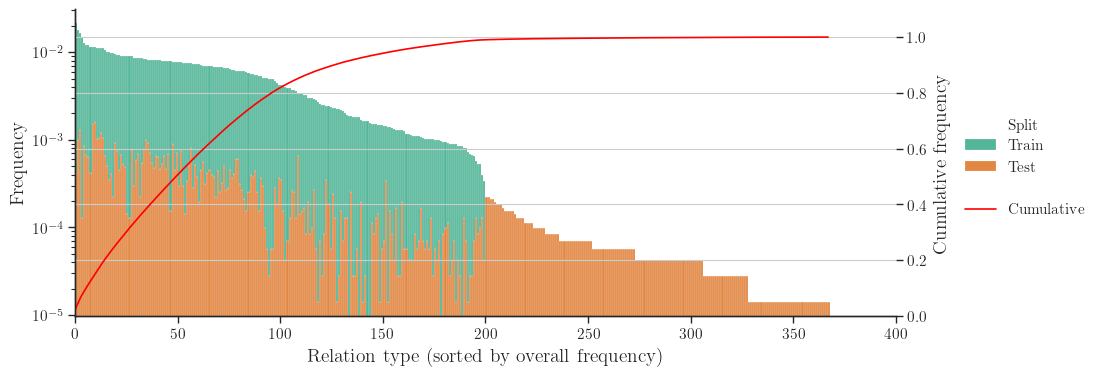

In [18]:
freq_map = {id: i for i, id in enumerate(to_plot_df.rel_id.values)}
new_df = pd.concat(
    [
        pd.DataFrame({"rel": [freq_map[x] for x in all_rels_train], "split": "train"}),
        pd.DataFrame({"rel": [freq_map[x] for x in all_rels_test], "split": "test"}),
    ]
)

rel_bincount = np.bincount(all_rels_train + all_rels_test, minlength=len(freq_map))
rel_bincount = rel_bincount[np.argsort(rel_bincount)][::-1] / np.sum(rel_bincount)
rel_bincount = rel_bincount[: len(freq_map)]

fig, ax = plt.subplots(figsize=(11, 4))
ax2 = plt.twinx(ax=ax)
sns.histplot(
    new_df,
    x="rel",
    hue="split",
    multiple="stack",
    stat="probability",
    bins=np.arange(400),
    ax=ax,
    label="split",
)
ax2.plot(np.arange(len(rel_bincount)), np.cumsum(rel_bincount), "r")

ax.set_xlim([0, 400])
ax2.set_ylim([0, 1.1])
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax2.set_ylabel("Cumulative frequency")
ax.set_xlabel("Relation type (sorted by overall frequency)")


dist_lines = [
    (name, dict(label=name, color=plot_utils.PALETTE[i]))
    for name, i in zip(["test", "train"], [0, 1])
]
dist_lines2 = [("cumulative", dict(label="cumulative", color="r"))]
build = ["split", *dist_lines, "", *dist_lines2]
handles_dist = plot_utils.build_legend_handles(*build)
handles_dist[1], handles_dist[2] = (
    ax.get_legend_handles_labels()[0][1],
    ax.get_legend_handles_labels()[0][0],
)
plot_utils.set_figure_legend(
    ax.figure, handles=handles_dist, labels=["Split", "Train", "Test", "", "Cumulative"]
)
ax.legend_.remove()
ax2.grid()
plot_utils.tidy(ax.figure)

## GTSQA Benchmarks

In [19]:
test_sp = json.load(
    open(
        "../results/eval_graphrag_sp.jsonl",
        "rb",
    )
)

test_def_gpt41 = json.load(
    open(
        "../results/eval_gpt4.1.jsonl",
        "rb",
    )
)
test_def_gpt4omini = json.load(
    open(
        "../results/eval_gpt4omini.jsonl",
        "rb",
    )
)

test_def_gpt5mini = json.load(
    open(
        "../results/eval_gpt5mini.jsonl",
        "rb",
    )
)

test_def_llama3 = json.load(
    open(
        "../results/eval_llama31-8b-instruct.jsonl",
        "rb",
    )
)

test_def_ministral8b = json.load(
    open(
        "../results/eval_ministral8b.jsonl",
        "rb",
    )
)

test_def_mistral_large = json.load(
    open(
        "../results/eval_mistral_large.jsonl",
        "rb",
    )
)


test_def_pog = json.load(
    open(
        "../results/pog_clean_corr.json",
        "rb",
    )
)

test_def_tog_orig = json.load(
    open(
        "../results/tog_original_clean_corr.json",
        "rb",
    )
)

test_def_sr = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_gt.json",
        "rb",
    )
)

test_def_sr2 = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_gt2.json",
        "rb",
    )
)

test_def_sr3 = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_gt3.json",
        "rb",
    )
)

test_def_gcr = json.load(
    open(
        "../results/GCR/GCR_gt/predictions_clean_corr.json",
        "rb",
    )
)

test_def_gcr2 = json.load(
    open(
        "../results/GCR/GCR_gt2/predictions_clean_corr.json",
        "rb",
    )
)

test_def_gcr3 = json.load(
    open(
        "../results/GCR/GCR_gt3/predictions_clean_corr.json",
        "rb",
    )
)

test_def_rog = json.load(
    open(
        "../results/RoG/RoG_gt/predictions_clean_corr.json",
        "rb",
    )
)

test_def_rog2 = json.load(
    open(
        "../results/RoG/RoG_gt2/predictions_clean_corr.json",
        "rb",
    )
)

test_def_rog3 = json.load(
    open(
        "../results/RoG/RoG_gt3/predictions_clean_corr.json",
        "rb",
    )
)

test_def_subgraphrag_res = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_gt1.json",
        "rb",
    )
)
test_def_subgraphrag_res2 = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_gt2.json",
        "rb",
    )
)
test_def_subgraphrag_res3 = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_gt3.json",
        "rb",
    )
)

In [20]:
models = {
    "ToG": [test_def_tog_orig],
    "PoG": [test_def_pog],
    "SR": [test_def_sr, test_def_sr2, test_def_sr3],
    "RoG": [test_def_rog, test_def_rog2, test_def_rog3],
    "GCR": [test_def_gcr, test_def_gcr2, test_def_gcr3],
    "SubgraphRAG (200)": [
        test_def_subgraphrag_res,
        test_def_subgraphrag_res2,
        test_def_subgraphrag_res3,
    ],
}

In [21]:
def exact_match(response, answers):
    clean_result = response.strip().replace(" ", "").lower()
    find_all = re.findall(r"\{(.*?)\}", clean_result)
    if len(find_all) > 0:
        if find_all[-1] not in ["yes", "no"]:
            final_ans = find_all[-1]
        else:
            final_ans = clean_result
    else:
        final_ans = clean_result
    answer_match = []
    for answer in answers:
        clean_answer = answer.strip().replace(" ", "").lower()
        if (
            final_ans == clean_answer
            or clean_answer in final_ans
            or final_ans in clean_answer
        ):
            answer_match.append(True)
        else:
            answer_match.append(False)
    return answer_match

In [22]:
all_res = []
for model_name, res_list in models.items():
    model_res = []
    for res in res_list:
        suffix = "_200" if "SubgraphRAG" in model_name else ""
        analysis = []
        print(model_name)
        for i, dp in enumerate(res):
            ans_stats = dict()
            ans_ids = [
                rev_lkp_ent.get(x, -1)
                for x in test_ds[id_to_i[dp["id"]]]["all_answers_wikikg2"]
            ]
            ans_ids = np.array([x for x in ans_ids if x != -1])
            answers_labels = [node_labels[x] for x in ans_ids]
            if "graphrag_subgraph" in dp:
                retr_triples = np.array(dp["graphrag_subgraph"])
                if suffix != "":
                    k = int(suffix.split("_")[-1])
                    retr_triples = retr_triples[:k]
                n_retr_triples = len(retr_triples)
                if len(retr_triples) == 0:
                    retr_triples = np.array([[-1, -1, -1]])
                gt_triples = np.array(
                    [
                        [rev_lkp_ent[h], rev_lkp_rel[r], rev_lkp_ent[t]]
                        for h, r, t in test_ds[id_to_i[dp["id"]]][
                            "full_answer_subgraph_wikikg2"
                        ]
                    ]
                )

                triple_hits = (
                    (retr_triples[None, :, :] == gt_triples[:, None, :])
                    .all(axis=-1)
                    .any(1)
                    .sum()
                )
                triple_recall = triple_hits / gt_triples.shape[0]
                triple_precision = (
                    triple_hits / n_retr_triples if n_retr_triples > 0 else 0
                )
                if triple_precision + triple_recall == 0.0:
                    triple_f1_score = 0.0
                else:
                    triple_f1_score = (
                        2
                        * triple_precision
                        * triple_recall
                        / (triple_precision + triple_recall)
                    )

                ans_present = [x for x in ans_ids if x in retr_triples[:, [0, 2]]]
                ans_recall = (
                    (retr_triples[:, [0, 2]].reshape(-1)[None, :] == ans_ids[:, None])
                ).any(axis=-1).sum() / len(answers_labels)

                ans_stats.update(
                    {
                        f"n_retr_triples": n_retr_triples,
                        f"gt_triple_recall": 100 * triple_recall,
                        f"gt_triple_precision": 100 * triple_precision,
                        f"gt_triple_f1": 100 * triple_f1_score,
                        f"ans_hits": 100 * (len(ans_present) > 0),
                        f"ans_recall": 100 * ans_recall,
                    }
                )

            graphrag_em = exact_match(dp["graphrag_answer" + suffix], answers_labels)

            test_type = test_ds[id_to_i[dp["id"]]]["test_type"]
            an_res = {
                "id": dp["id"],
                "question": dp["question"],
                "n_hops": dp["n_hops"],
                "graph_template": test_ds[id_to_i[dp["id"]]]["graph_isomorphism"],
                "n_edges": len(dp["answer_subgraph"]),
                "n_seeds": len(dp["seed_nodes_id"]),
                "graphrag_hits": 100 * any(graphrag_em),
                "graphrag_recall": 100 * np.mean(graphrag_em).item(),
                "test_type": (
                    "unseen_graph_type" if len(test_type) > 1 else test_type[0]
                ),
            }
            an_res.update(ans_stats)
            analysis.append(an_res)

        anal_df = pd.DataFrame(analysis)
        anal_df["model"] = model_name
        all_res.append(anal_df)

all_res_df = pd.concat(all_res)

ToG
PoG
SR
SR
SR
RoG
RoG
RoG
GCR
GCR
GCR
SubgraphRAG (200)
SubgraphRAG (200)
SubgraphRAG (200)


In [23]:
all_res_stats = (
    all_res_df.groupby(["model"], as_index=False)[
        [
            "graphrag_hits",
            "graphrag_recall",
            "n_retr_triples",
            "gt_triple_recall",
            "gt_triple_precision",
            "gt_triple_f1",
            "ans_hits",
            "ans_recall",
        ]
    ]
    .mean()
    .sort_values("graphrag_hits")
)

model_types = pd.DataFrame(
    {
        "model": ["PoG", "ToG", "SR", "RoG", "GCR", "SubgraphRAG (200)"],
        "model_type": [
            "KG agent",
            "KG agent",
            "Path-based",
            "Path-based",
            "Path-based",
            "All-at-once",
        ],
    }
)
all_res_stats = pd.merge(all_res_stats, model_types, on="model")
all_res_stats

,model,graphrag_hits,graphrag_recall,n_retr_triples,gt_triple_recall,gt_triple_precision,gt_triple_f1,ans_hits,ans_recall,model_type
0,PoG,32.922318,31.595913,7.086313,31.954156,27.515196,27.026308,31.812577,30.543714,KG agent
1,SR,40.628853,39.102666,72.939581,30.224068,3.441621,5.690239,50.246609,49.385630,Path-based
2,ToG,45.684340,44.472433,8.705302,35.497182,6.446808,10.502737,41.553637,40.973666,KG agent
3,GCR,49.907503,48.246024,6.541213,40.705995,27.205140,29.823903,47.112025,45.543777,Path-based
4,RoG,57.583231,55.775742,72.154747,54.692375,24.042414,27.004573,72.914098,71.844431,Path-based
5,SubgraphRAG (200),61.590629,58.619641,199.614673,79.091117,1.289341,2.526066,85.326757,84.361100,All-at-once


In [24]:
all_res_stats = (
    all_res_df.groupby(["model"], as_index=False)[
        [
            "graphrag_hits",
            "graphrag_recall",
            "n_retr_triples",
            "gt_triple_recall",
            "gt_triple_precision",
            "gt_triple_f1",
            "ans_hits",
            "ans_recall",
        ]
    ]
    .mean()
    .sort_values("graphrag_hits")
)

model_types = pd.DataFrame(
    {
        "model": ["PoG", "ToG", "SR", "RoG", "GCR", "SubgraphRAG (200)"],
        "model_type": [
            "KG agent",
            "KG agent",
            "Path-based",
            "Path-based",
            "Path-based",
            "All-at-once",
        ],
    }
)
all_res_stats = pd.merge(all_res_stats, model_types, on="model")
all_res_stats

,model,graphrag_hits,graphrag_recall,n_retr_triples,gt_triple_recall,gt_triple_precision,gt_triple_f1,ans_hits,ans_recall,model_type
0,PoG,32.922318,31.595913,7.086313,31.954156,27.515196,27.026308,31.812577,30.543714,KG agent
1,SR,40.628853,39.102666,72.939581,30.224068,3.441621,5.690239,50.246609,49.385630,Path-based
2,ToG,45.684340,44.472433,8.705302,35.497182,6.446808,10.502737,41.553637,40.973666,KG agent
3,GCR,49.907503,48.246024,6.541213,40.705995,27.205140,29.823903,47.112025,45.543777,Path-based
4,RoG,57.583231,55.775742,72.154747,54.692375,24.042414,27.004573,72.914098,71.844431,Path-based
5,SubgraphRAG (200),61.590629,58.619641,199.614673,79.091117,1.289341,2.526066,85.326757,84.361100,All-at-once


In [25]:
LLMs = {
    "LLama-3.1-8B-Instruct": test_def_llama3,
    "GPT-4.1": test_def_gpt41,
    "GPT-4o-mini": test_def_gpt4omini,
    "GPT-5-mini": test_def_gpt5mini,
    "Ministral-8B-Instruct": test_def_ministral8b,
    "Mistral-Large-2.1": test_def_mistral_large,
}

all_res_llm = []
for model_name, res in LLMs.items():
    llm_analysis = []
    print(model_name)
    for dp in res:
        ans_ids = [
            rev_lkp_ent.get(x, -1)
            for x in test_ds[id_to_i[dp["id"]]]["all_answers_wikikg2"]
        ]
        ans_ids = np.array([x for x in ans_ids if x != -1])
        answers_labels = [node_labels[x] for x in ans_ids]

        an_res = {
            "id": dp["id"],
            "question": dp["question"],
            "n_hops": dp["n_hops"],
            "graph_template": test_ds[id_to_i[dp["id"]]]["graph_isomorphism"],
            "n_edges": len(dp["answer_subgraph"]),
            "n_seeds": len(dp["seed_nodes_id"]),
            "io_hits": 100
            * np.mean(
                [
                    any(exact_match(dp[l], answers_labels))
                    for l in dp.keys()
                    if "io_answer_" in l
                ]
            ),
            "io_recall": 100
            * np.mean(
                [
                    np.mean(exact_match(dp[l], answers_labels)).item()
                    for l in dp.keys()
                    if "io_answer_" in l
                ]
            ),
            "cot_hits": 100
            * np.mean(
                [
                    any(exact_match(dp[l], answers_labels))
                    for l in dp.keys()
                    if "cot_answer_" in l
                ]
            ),
            "cot_recall": 100
            * np.mean(
                [
                    np.mean(exact_match(dp[l], answers_labels)).item()
                    for l in dp.keys()
                    if "cot_answer_" in l
                ]
            ),
            "test_type": ("unseen_graph_type" if len(test_type) > 1 else test_type[0]),
        }
        llm_analysis.append(an_res)
    llm_df = pd.DataFrame(llm_analysis)
    llm_df["model"] = model_name
    all_res_llm.append(llm_df)

LLama-3.1-8B-Instruct
GPT-4.1
GPT-4o-mini
GPT-5-mini
Ministral-8B-Instruct
Mistral-Large-2.1


In [26]:
all_res_llm_df = pd.concat(all_res_llm)
all_res_llm_df_stats = (
    all_res_llm_df.groupby(["model"], as_index=False)[
        [
            "io_hits",
            "io_recall",
            "cot_hits",
            "cot_recall",
        ]
    ]
    .mean()
    .sort_values("cot_hits")
)
all_res_llm_df_stats["graphrag_hits"] = all_res_llm_df_stats.apply(
    lambda x: max(x["io_hits"], x["cot_hits"]), axis=1
)
all_res_llm_df_stats["graphrag_recall"] = all_res_llm_df_stats.apply(
    lambda x: max(x["io_recall"], x["cot_recall"]), axis=1
)
all_res_llm_df_stats[["model", "graphrag_hits", "graphrag_recall"]].sort_values(
    "graphrag_hits"
)
all_res_llm_df_stats["model_type"] = "LLM"

In [27]:
# Table 2

overall_comparison = pd.concat(
    [
        all_res_llm_df_stats[
            ["model_type", "model", "graphrag_hits", "graphrag_recall"]
        ],
        all_res_stats,
    ],
    axis=0,
).fillna("-")
overall_comparison

,model_type,model,graphrag_hits,graphrag_recall,n_retr_triples,gt_triple_recall,gt_triple_precision,gt_triple_f1,ans_hits,ans_recall
4,LLM,Ministral-8B-Instruct,10.727497,10.161177,-,-,-,-,-,-
3,LLM,LLama-3.1-8B-Instruct,17.108508,16.328680,-,-,-,-,-,-
1,LLM,GPT-4o-mini,20.900123,19.933357,-,-,-,-,-,-
5,LLM,Mistral-Large-2.1,23.612824,22.846574,-,-,-,-,-,-
2,LLM,GPT-5-mini,31.442663,30.196504,-,-,-,-,-,-
0,LLM,GPT-4.1,33.970407,32.830427,-,-,-,-,-,-
0,KG agent,PoG,32.922318,31.595913,7.086313,31.954156,27.515196,27.026308,31.812577,30.543714
1,Path-based,SR,40.628853,39.102666,72.939581,30.224068,3.441621,5.690239,50.246609,49.38563
2,KG agent,ToG,45.684340,44.472433,8.705302,35.497182,6.446808,10.502737,41.553637,40.973666
3,Path-based,GCR,49.907503,48.246024,6.541213,40.705995,27.20514,29.823903,47.112025,45.543777


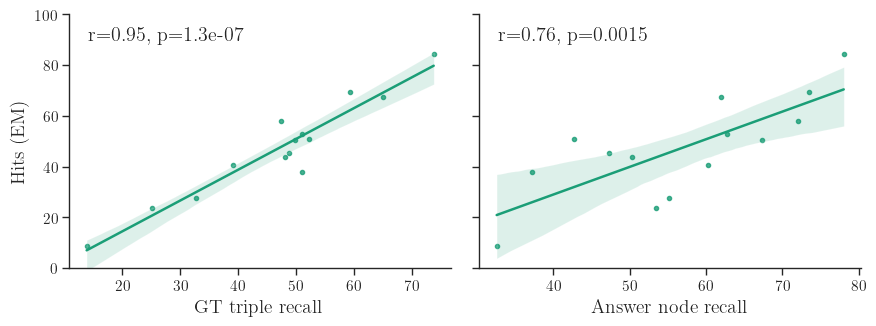

In [28]:
data = all_res_df.groupby(["graph_template"], as_index=False)[
    ["gt_triple_recall", "ans_recall", "graphrag_hits"]
].mean()

fig, axn = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)

for i, metric in enumerate(["gt_triple_recall", "ans_recall"]):
    ax = axn[i]
    sns.regplot(data=data, x=metric, y="graphrag_hits", ax=ax)
    r, p = sp.stats.pearsonr(data[metric], data.graphrag_hits)
    ax.text(0.05, 0.9, f"r={r:.2f}, p={p:.2g}", transform=ax.transAxes)

axn[0].set_ylabel("Hits (EM)")
axn[1].set_ylabel("")
axn[0].set_ylim([0, 100])
axn[0].set_xlabel("GT triple recall")
axn[1].set_xlabel("Answer node recall")

plot_utils.tidy(axn[0].figure)

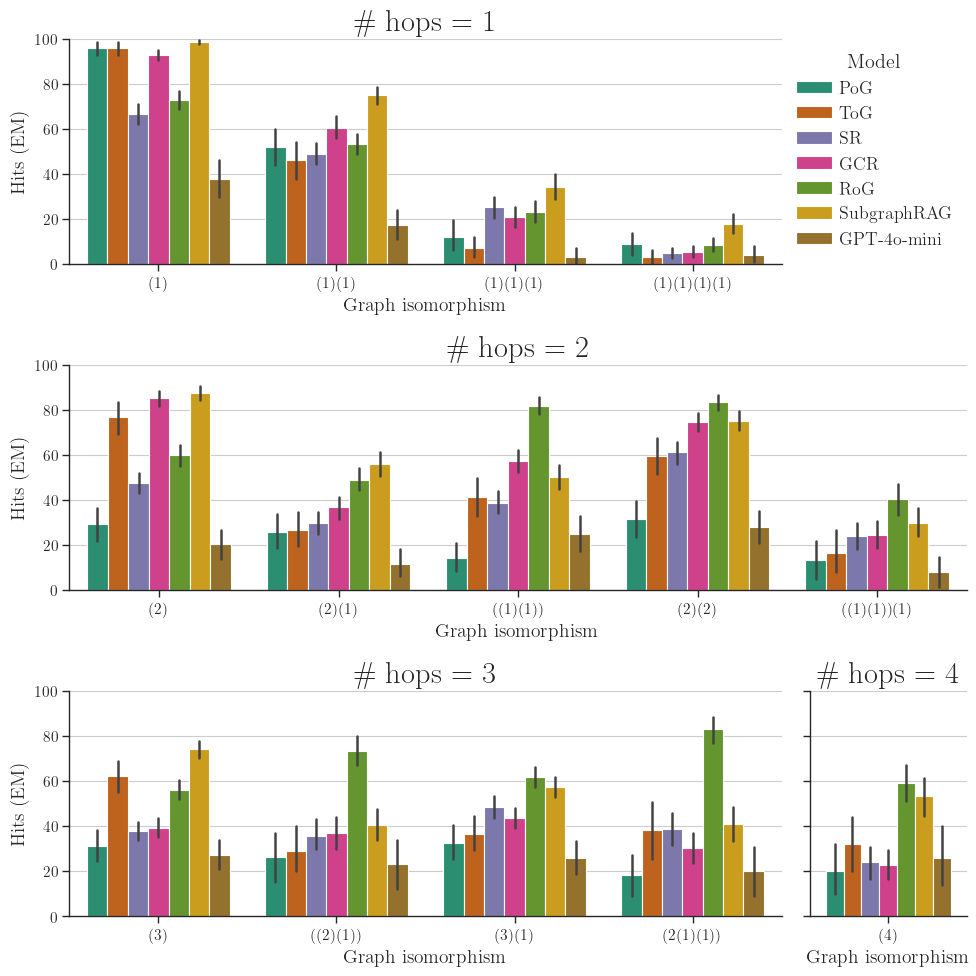

In [29]:
all_res_comb = pd.concat(
    [
        all_res_df,
        all_res_llm_df.query("model=='GPT-4o-mini'").rename(
            columns={"cot_hits": "graphrag_hits"}
        ),
    ],
    axis=0,
)

to_agg = "n_hops"
unique_vals = np.unique(all_res_df[to_agg].values)

fig = plt.figure(figsize=(10, 2.5 * len(unique_vals)))
gs = fig.add_gridspec(nrows=3, ncols=5)
ax0 = fig.add_subplot(gs[0, :4])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :4])
ax3 = fig.add_subplot(gs[2, -1])
axn = [ax0, ax1, ax2, ax3]

mod_sorted = ["PoG", "ToG", "SR", "GCR", "RoG", "SubgraphRAG", "GPT-4o-mini"]

for j, val in enumerate(unique_vals):
    ax = axn[j]
    to_plot = all_res_comb.query(f"{to_agg} == {val}").sort_values(
        "n_edges", ascending=True
    )
    to_plot["model"] = to_plot.apply(
        lambda x: x["model"] if "SubgraphRAG" not in x["model"] else "SubgraphRAG",
        axis=1,
    )
    sns.barplot(
        x="graph_template",
        y="graphrag_hits",
        hue="model",
        hue_order=mod_sorted,
        data=to_plot,
        ax=ax,
    )
    ax.set_xlabel("Graph isomorphism")
    ax.get_legend().remove()
    ax.set_ylim([0, 100])
    ax.set_title(f"\# hops = {val}", fontsize=22)
    if j < 3:
        ax.set_ylabel("Hits (EM)")
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])

    ax.grid(axis="y")

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title="Model",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.95),
    ncols=1,
    columnspacing=1.25,
    handletextpad=0.4,
    fontsize=13,
)
plot_utils.tidy(ax.figure)

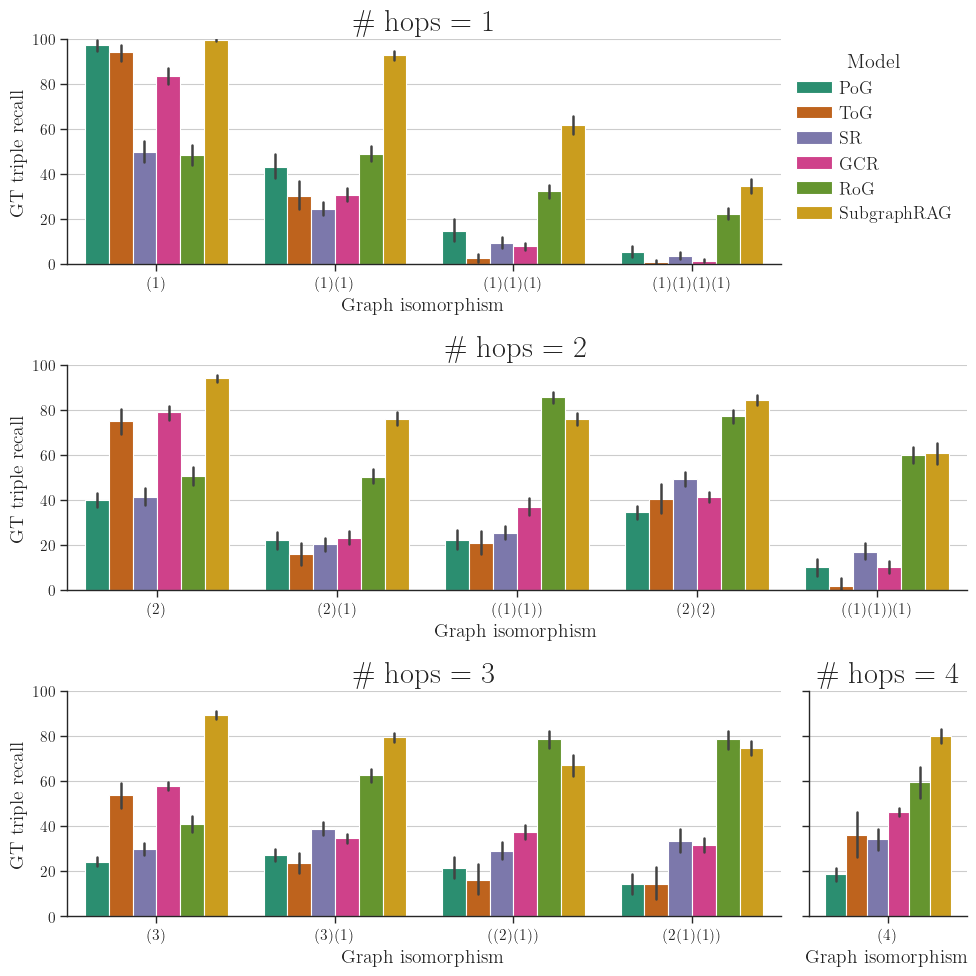

In [30]:
to_agg = "n_hops"
unique_vals = np.unique(all_res_df[to_agg].values)

fig = plt.figure(figsize=(10, 2.5 * len(unique_vals)))
gs = fig.add_gridspec(nrows=3, ncols=5)
ax0 = fig.add_subplot(gs[0, :4])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :4])
ax3 = fig.add_subplot(gs[2, -1])
axn = [ax0, ax1, ax2, ax3]

mod_sorted = ["PoG", "ToG", "SR", "GCR", "RoG", "SubgraphRAG"]

for j, val in enumerate(unique_vals):
    ax = axn[j]
    to_plot = all_res_comb.query(
        f"{to_agg} == {val} and model != 'GPT-4o-mini'"
    ).sort_values("n_edges", ascending=True)
    to_plot["model"] = to_plot.apply(
        lambda x: x["model"] if "SubgraphRAG" not in x["model"] else "SubgraphRAG",
        axis=1,
    )
    sns.barplot(
        x="graph_template",
        y="gt_triple_recall",
        hue="model",
        hue_order=mod_sorted,
        data=to_plot,
        ax=ax,
    )
    ax.set_xlabel("Graph isomorphism")
    ax.get_legend().remove()
    ax.set_ylim([0, 100])
    ax.set_title(f"\# hops = {val}", fontsize=22)
    if j < 3:
        ax.set_ylabel("GT triple recall")
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])

    ax.grid(axis="y")

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title="Model",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.95),
    ncols=1,
    columnspacing=1.25,
    handletextpad=0.4,
    fontsize=13,
)
plot_utils.tidy(ax.figure)

/tmp/ipykernel_40521/253027987.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]
/tmp/ipykernel_40521/253027987.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]
/tmp/ipykernel_40521/253027987.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

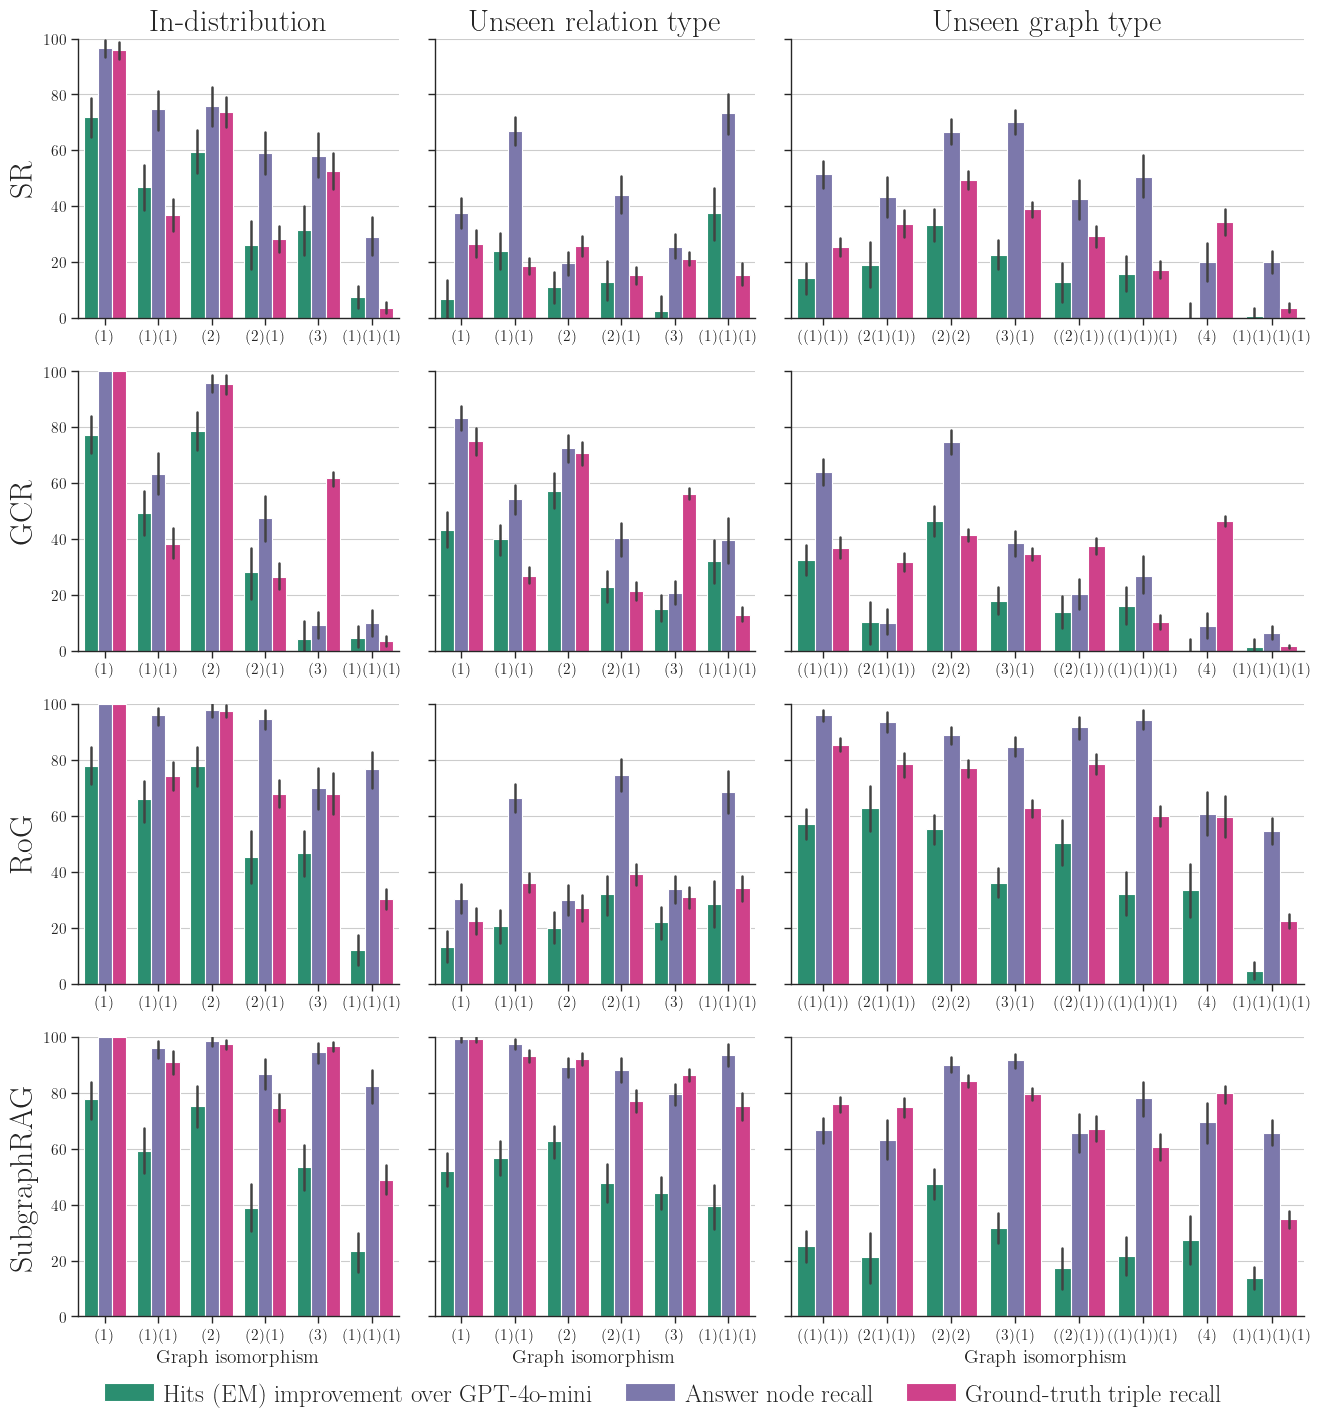

In [31]:
all_res_comb = pd.merge(
    all_res_df,
    all_res_llm_df.query("model=='GPT-4o-mini'")[["id", "cot_hits"]],
    on="id",
)

to_agg = "test_type"
unique_vals = ["in_distribution", "unseen_relation_type", "unseen_graph_type"]
vals_mapping = {
    "in_distribution": "In-distribution",
    "unseen_relation_type": "Unseen relation type",
    "unseen_graph_type": "Unseen graph type",
}

mod_sorted = ["SR", "GCR", "RoG", "SubgraphRAG (200)"]
graph_sorted = {
    "in_distribution": ["(1)", "(1)(1)", "(2)", "(2)(1)", "(3)", "(1)(1)(1)"],
    "unseen_relation_type": ["(1)", "(1)(1)", "(2)", "(2)(1)", "(3)", "(1)(1)(1)"],
    "unseen_graph_type": [
        "((1)(1))",
        "(2(1)(1))",
        "(2)(2)",
        "(3)(1)",
        "((2)(1))",
        "((1)(1))(1)",
        "(4)",
        "(1)(1)(1)(1)",
    ],
}

fig, axn = plt.subplots(
    len(mod_sorted),
    len(unique_vals),
    figsize=(4.5 * len(unique_vals), 3.5 * len(mod_sorted)),
    sharey=True,
    gridspec_kw={"width_ratios": [1, 1, 1.6]},
)

for i, mod in enumerate(mod_sorted):
    for j, val in enumerate(unique_vals):
        ax = axn[i, j]
        to_plot = all_res_comb.query(f"model == '{mod}' and {to_agg} == '{val}'")
        to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]

        tidy = (
            to_plot[
                [
                    "graph_template",
                    # "graphrag_hits",
                    # "cot_hits",
                    "em_diff",
                    "ans_recall",
                    "gt_triple_recall",
                ]
            ]
            .rename(
                columns={
                    "graph_template": "Graph isomorphism",
                    # "graphrag_hits": "KG-RAG EM",
                    # "cot_hits": "GPT-4o-mini EM",
                    "em_diff": "Hits (EM) improvement over GPT-4o-mini",
                    "ans_recall": "Answer node recall",
                    "gt_triple_recall": "Ground-truth triple recall",
                }
            )
            .melt(id_vars="Graph isomorphism")
        )
        sns.barplot(
            x="Graph isomorphism",
            y="value",
            hue="variable",
            data=tidy,
            ax=ax,
            palette=[
                plot_utils.PALETTE[0],
                plot_utils.PALETTE[2],
                plot_utils.PALETTE[3],
            ],
            order=graph_sorted[val],
        )
        # ax.bar_label(ax.containers[0], labels=to_plot["count"])
        if i == 0:
            ax.set_title(vals_mapping[val], fontsize=22)
        if i < len(mod_sorted) - 1:
            ax.set_xlabel("")
        # if i < len(unique_vals) - 1:
        ax.get_legend().remove()
        ax.set_ylim([0, 100])
        ax.set_ylabel("SubgraphRAG" if "SubgraphRAG" in mod else mod, fontsize=23)
        ax.grid(axis="y")

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title=f"",
    bbox_to_anchor=(0.0, -0.03, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    columnspacing=1.25,
    handletextpad=0.4,
    fontsize=18,
)
plot_utils.tidy(ax.figure)

/tmp/ipykernel_40521/2903563239.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]
/tmp/ipykernel_40521/2903563239.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_40521/2903563239.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]
/tmp/ipykernel_40

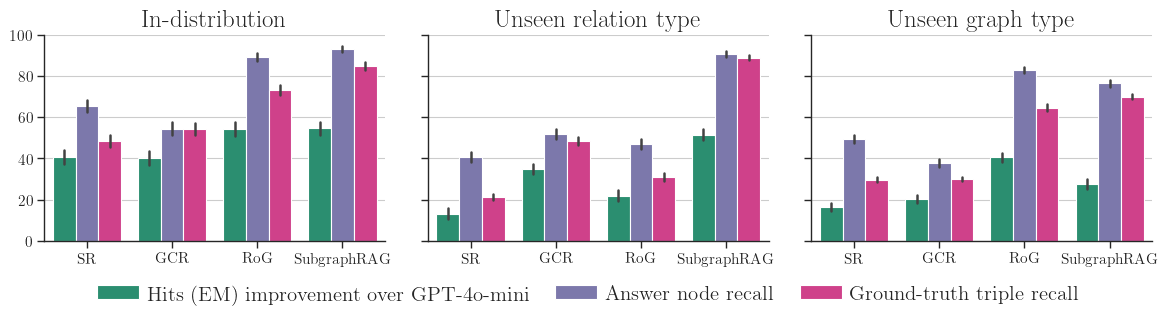

In [32]:
fig, axn = plt.subplots(
    1,
    len(unique_vals),
    figsize=(4 * len(unique_vals), 3),
    sharey=True,
)

# for i, stat in enumerate(stats):
for j, val in enumerate(unique_vals):
    ax = axn[j]
    to_plot = all_res_comb.query(f"model in {mod_sorted} and {to_agg} == '{val}'")
    to_plot["em_diff"] = to_plot["graphrag_hits"] - to_plot["cot_hits"]

    tidy = (
        to_plot[
            [
                "model",
                "em_diff",
                "ans_recall",
                "gt_triple_recall",
            ]
        ]
        .rename(
            columns={
                "model": "Model",
                "em_diff": "Hits (EM) improvement over GPT-4o-mini",
                "ans_recall": "Answer node recall",
                "gt_triple_recall": "Ground-truth triple recall",
            }
        )
        .melt(id_vars="Model")
    )
    sns.barplot(
        x="Model",
        y="value",
        hue="variable",
        data=tidy,
        ax=ax,
        order=mod_sorted,
        palette=[
            plot_utils.PALETTE[0],
            plot_utils.PALETTE[2],
            plot_utils.PALETTE[3],
        ],
        # hue_order=stats,
    )
    # ax.bar_label(ax.containers[0], labels=to_plot["count"])
    ax.set_title(vals_mapping[val], fontsize=18)
    ax.get_legend().remove()
    ax.set_ylim([0, 100])
    ax.set_ylabel("", fontsize=20)
    ax.set_xlabel("", fontsize=20)
    ax.grid(axis="y")
    ax.set_xticklabels(
        [x if "Subgraph" not in x else "SubgraphRAG" for x in mod_sorted]
    )

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title=f"",
    bbox_to_anchor=(0.0, -0.12, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    columnspacing=1.25,
    handletextpad=0.4,
    fontsize=15,
)
plot_utils.tidy(ax.figure)

## Shortest paths vs Ground truth paths

### Statistics

In [33]:
train_ds_w_sp = pickle.load(
    open(
        "../data/train_sp.pkl",
        "rb",
    )
)
test_ds_w_sp = pickle.load(
    open(
        "../data/test_sp.pkl",
        "rb",
    )
)

In [34]:
all_paths_gt = []
all_paths_sp = []

lens_gt_paths = {1: [], 2: [], 3: [], 4: [], 5: []}
lens_sp_paths = {1: [], 2: [], 3: [], 4: [], 5: []}
nums_gt_paths = {1: [], 2: [], 3: [], 4: [], 5: []}
nums_sp_paths = {1: [], 2: [], 3: [], 4: [], 5: []}
for dp in tqdm(train_ds_w_sp):
    for sa, gt_sa_path_list in dp["seed_answer_paths"].items():
        assert len(gt_sa_path_list) == 1
        gt_path_leng = len(gt_sa_path_list[0])
        sp_path_lens = [len(p) for p in dp["seed_answer_paths_sp"][sa]]
        lens_gt_paths[gt_path_leng].append(gt_path_leng)
        lens_sp_paths[gt_path_leng].append(np.mean(sp_path_lens))
        nums_gt_paths[gt_path_leng].append(len(gt_sa_path_list))
        nums_sp_paths[gt_path_leng].append(len(sp_path_lens))

        all_paths_gt.extend([gt_path_leng])
        all_paths_sp.extend(sp_path_lens)

 73%|███████▎  | 22120/30477 [00:00<00:00, 61025.00it/s]/nethome/albertoc/research/knowledge_graphs/synth-kgqa/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nethome/albertoc/research/knowledge_graphs/synth-kgqa/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 30477/30477 [00:00<00:00, 65422.40it/s]


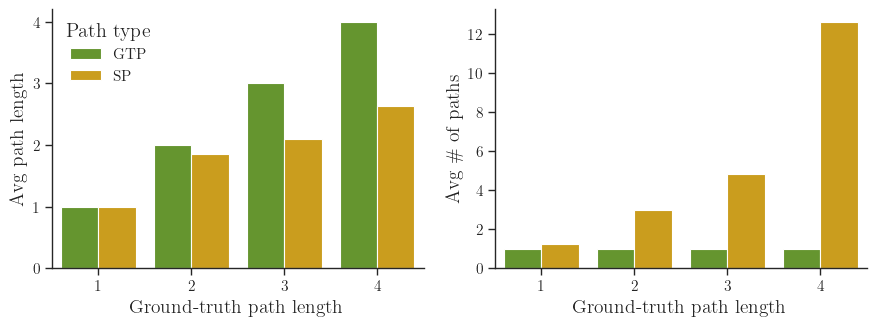

In [35]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3.5))

gt_num_df = pd.DataFrame(
    {k: [np.mean(nums_gt_paths[k])] for k in nums_gt_paths.keys()}
).T.rename({0: "avg_num_paths"}, axis=1)
gt_num_df["Path type"] = "GTP"
sp_num_df = pd.DataFrame(
    {k: [np.mean(nums_sp_paths[k])] for k in nums_sp_paths.keys()}
).T.rename({0: "avg_num_paths"}, axis=1)
sp_num_df["Path type"] = "SP"
all_tog = pd.concat([gt_num_df.drop(5), sp_num_df.drop(5)])

sns.barplot(
    x=all_tog.index,
    y=all_tog.avg_num_paths,
    hue=all_tog["Path type"],
    ax=ax1,
    palette=[plot_utils.PALETTE[4], plot_utils.PALETTE[5]],
)
ax1.set_xlabel("Ground-truth path length")
ax1.set_ylabel("Avg \# of paths")
# ax1.set_ylim([0,10])
ax1.legend_.remove()

gt_num_df = pd.DataFrame(
    {k: [np.mean(lens_gt_paths[k])] for k in nums_gt_paths.keys()}
).T.rename({0: "avg_path_len"}, axis=1)
gt_num_df["Path type"] = "GTP"
sp_num_df = pd.DataFrame(
    {k: [np.mean(lens_sp_paths[k])] for k in nums_sp_paths.keys()}
).T.rename({0: "avg_path_len"}, axis=1)
sp_num_df["Path type"] = "SP"
all_tog = pd.concat([gt_num_df.drop(5), sp_num_df.drop(5)])

sns.barplot(
    x=all_tog.index,
    y=all_tog.avg_path_len,
    hue=all_tog["Path type"],
    ax=ax0,
    palette=[plot_utils.PALETTE[4], plot_utils.PALETTE[5]],
)
ax0.set_xlabel("Ground-truth path length")
ax0.set_ylabel("Avg path length")

plot_utils.tidy(ax0.figure)

In [36]:
sp_gt_res = []
for i, dp in enumerate(test_sp):
    gt_triples = np.array(dp["answer_subgraph"])
    ans_ids = [
        rev_lkp_ent.get(x, -1)
        for x in test_ds[id_to_i[dp["id"]]]["all_answers_wikikg2"]
    ]
    ans_ids = np.array([x for x in ans_ids if x != -1])
    answers_labels = [node_labels[x] for x in ans_ids]
    retr_triples = np.array(dp["full_subgraph_sp"])
    n_retr_triples = len(retr_triples)

    if len(retr_triples) == 0:
        retr_triples = np.array([[-1, -1, -1]])

    triple_hits = (
        (retr_triples[None, :, :] == gt_triples[:, None, :]).all(axis=-1).any(1).sum()
    )
    triple_recall = triple_hits / gt_triples.shape[0]
    triple_precision = triple_hits / n_retr_triples
    if triple_precision + triple_recall == 0.0:
        triple_f1_score = 0.0
    else:
        triple_f1_score = (
            2 * triple_precision * triple_recall / (triple_precision + triple_recall)
        )

    ans_present = [x for x in ans_ids if x in retr_triples[:, [0, 2]]]
    ans_recall = (
        (retr_triples[:, [0, 2]].reshape(-1)[None, :] == ans_ids[:, None])
    ).any()

    ans_stats = {
        f"n_gt_triples": len(gt_triples),
        f"n_sp_triples": n_retr_triples,
        f"gt_triple_recall": 100 * triple_recall,
        f"gt_triple_precision": 100 * triple_precision,
        f"gt_triple_f1": triple_f1_score,
        f"ans_recall": len(ans_present) > 0,
    }

    an_res = {
        "i": i,
        "question": dp["question"],
        "graph_template": dp["graph_template"],
        "n_edges": len(dp["answer_subgraph"]),
        "n_hops": dp["n_hops"],
        "graphrag_hits": 100
        * np.mean(
            [
                any(exact_match(dp[f"graphrag_answer_{k}"], answers_labels))
                for k in range(2)
            ]
        ),
        "n_gt_triples": len(dp["full_subgraph"]),
        "n_sp_triples": len(dp["full_subgraph_sp"]),
    }
    an_res.update(ans_stats)
    sp_gt_res.append(an_res)

analysis_sp = pd.DataFrame(sp_gt_res)

In [37]:
# Table B2

analysis_sp.groupby(["n_hops"], as_index=False)[
    [
        "n_gt_triples",
        "n_sp_triples",
        "gt_triple_recall",
        "gt_triple_precision",
        "ans_recall",
    ]
].mean().rename(
    columns={
        "n_hops": "# hops",
        "gt_triple_recall": "\% GT triples in SP set",
        "gt_triple_precision": "\% SP triples in GT set",
        "n_gt_triples": "# GT triples",
        "n_sp_triples": "# SP triples",
    }
)

,# hops,# GT triples,# SP triples,\% GT triples in SP set,\% SP triples in GT set,ans_recall
0,1,2.372361,2.673704,100.000000,90.993282,1.0
1,2,3.081531,19.635607,89.753189,52.722347,1.0
2,3,3.600000,46.273333,54.722222,29.635243,1.0
3,4,4.000000,10.440000,27.500000,13.325077,1.0


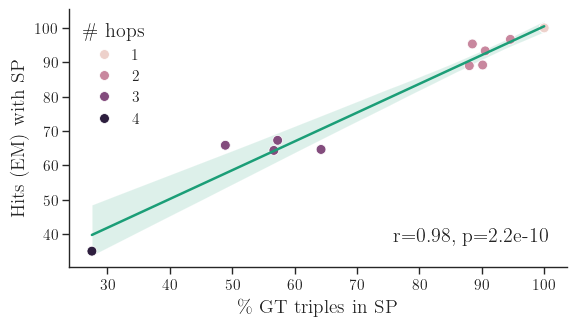

In [38]:
fig, ax = plt.subplots(figsize=(6, 3.5))

to_plot = (
    analysis_sp.groupby(["graph_template"])[
        [
            "graphrag_hits",
            "gt_triple_recall",
            "gt_triple_precision",
            "ans_recall",
            "n_gt_triples",
            "n_sp_triples",
            "n_hops",
        ]
    ]
    .mean()
    .rename(columns={"n_hops": "\# hops"})
)
to_plot["\# hops"] = to_plot["\# hops"].astype(np.int32)
sns.regplot(data=to_plot, x="gt_triple_recall", y="graphrag_hits", ax=ax)
sns.scatterplot(
    data=to_plot,
    x="gt_triple_recall",
    y="graphrag_hits",
    hue="\# hops",
    s=50,
)

r, p = sp.stats.pearsonr(to_plot.gt_triple_recall, to_plot.graphrag_hits)
ax.text(0.65, 0.1, "r={:.2f}, p={:.2g}".format(r, p), transform=ax.transAxes)
ax.set_xlabel("\% GT triples in SP")
ax.set_ylabel("Hits (EM) with SP")
plot_utils.tidy(ax.figure)

### Benchmarks

In [39]:
test_def_sr_sp = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_sp.json",
        "rb",
    )
)

test_def_sr_sp2 = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_sp2.json",
        "rb",
    )
)

test_def_sr_sp3 = json.load(
    open(
        "../results/SR/synthetic_def_sr_150_sp3.json",
        "rb",
    )
)

test_def_rog_sp = json.load(
    open(
        "../results/RoG/RoG_sp/predictions_clean_corr.json",
        "rb",
    )
)

test_def_rog_sp2 = json.load(
    open(
        "../results/RoG/RoG_sp2/predictions_clean_corr.json",
        "rb",
    )
)

test_def_rog_sp3 = json.load(
    open(
        "../results/RoG/RoG_sp3/predictions_clean_corr.json",
        "rb",
    )
)


test_def_subgraphrag_sp_res = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_sp1.json",
        "rb",
    )
)
test_def_subgraphrag_sp_res2 = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_sp2.json",
        "rb",
    )
)
test_def_subgraphrag_sp_res3 = json.load(
    open(
        "../results/SubgraphRAG/synthetic_def_subgraphrag_sweep_sp3.json",
        "rb",
    )
)

In [40]:
models_sp = {
    "SR": [test_def_sr_sp, test_def_sr_sp2, test_def_sr_sp3],
    "RoG": [test_def_rog_sp, test_def_rog_sp2, test_def_rog_sp3],
    "SubgraphRAG (200)": [
        test_def_subgraphrag_sp_res,
        test_def_subgraphrag_sp_res2,
        test_def_subgraphrag_sp_res3,
    ],
}

In [41]:
all_res_sp = []
for model_name, res_list in models_sp.items():
    model_res = []
    for res in res_list:
        suffix = "_200" if "SubgraphRAG" in model_name else ""
        analysis = []
        print(model_name)
        for i, dp in enumerate(res):
            ans_stats = dict()
            ans_ids = [
                rev_lkp_ent.get(x, -1)
                for x in test_ds[id_to_i[dp["id"]]]["all_answers_wikikg2"]
            ]
            ans_ids = np.array([x for x in ans_ids if x != -1])
            answers_labels = [node_labels[x] for x in ans_ids]
            if "graphrag_subgraph" in dp:
                retr_triples = np.array(dp["graphrag_subgraph"])
                if suffix != "":
                    k = int(suffix.split("_")[-1])
                    retr_triples = retr_triples[:k]
                n_retr_triples = len(retr_triples)
                if len(retr_triples) == 0:
                    retr_triples = np.array([[-1, -1, -1]])
                gt_triples = np.array(
                    [
                        [rev_lkp_ent[h], rev_lkp_rel[r], rev_lkp_ent[t]]
                        for h, r, t in test_ds[id_to_i[dp["id"]]][
                            "full_answer_subgraph_wikikg2"
                        ]
                    ]
                )

                triple_hits = (
                    (retr_triples[None, :, :] == gt_triples[:, None, :])
                    .all(axis=-1)
                    .any(1)
                    .sum()
                )
                triple_recall = triple_hits / gt_triples.shape[0]
                triple_precision = (
                    triple_hits / n_retr_triples if n_retr_triples > 0 else 0.0
                )
                if triple_precision + triple_recall == 0.0:
                    triple_f1_score = 0.0
                else:
                    triple_f1_score = (
                        2
                        * triple_precision
                        * triple_recall
                        / (triple_precision + triple_recall)
                    )

                ans_present = [x for x in ans_ids if x in retr_triples[:, [0, 2]]]
                ans_recall = (
                    (retr_triples[:, [0, 2]].reshape(-1)[None, :] == ans_ids[:, None])
                ).any(axis=-1).sum() / len(answers_labels)

                ans_stats.update(
                    {
                        f"n_retr_triples": n_retr_triples,
                        f"gt_triple_recall": 100 * triple_recall,
                        f"gt_triple_precision": 100 * triple_precision,
                        f"gt_triple_f1": 100 * triple_f1_score,
                        f"ans_hits": 100 * (len(ans_present) > 0),
                        f"ans_recall": 100 * ans_recall,
                    }
                )

            graphrag_em = exact_match(dp["graphrag_answer" + suffix], answers_labels)

            test_type = test_ds[id_to_i[dp["id"]]]["test_type"]
            an_res = {
                "id": dp["id"],
                "question": dp["question"],
                "n_hops": dp["n_hops"],
                "graph_template": test_ds[id_to_i[dp["id"]]]["graph_isomorphism"],
                "n_edges": len(dp["answer_subgraph"]),
                "n_seeds": len(dp["seed_nodes_id"]),
                "graphrag_hits": 100 * any(graphrag_em),
                "graphrag_recall": 100 * np.mean(graphrag_em).item(),
                "test_type": (
                    "unseen_graph_type" if len(test_type) > 1 else test_type[0]
                ),
            }
            an_res.update(ans_stats)
            analysis.append(an_res)

        anal_df = pd.DataFrame(analysis)
        anal_df["model"] = model_name
        all_res_sp.append(anal_df)

all_res_sp_df = pd.concat(all_res_sp)

SR
SR
SR
RoG
RoG
RoG
SubgraphRAG (200)
SubgraphRAG (200)
SubgraphRAG (200)


In [42]:
# Table 3

all_res_sp_stats = (
    all_res_sp_df.groupby(["model"], as_index=False)[
        [
            "graphrag_hits",
            "graphrag_recall",
            "n_retr_triples",
            "gt_triple_recall",
            "gt_triple_precision",
            "gt_triple_f1",
            "ans_hits",
            "ans_recall",
        ]
    ]
    .mean()
    .sort_values("graphrag_hits")
)

all_res_sp_stats = pd.merge(all_res_sp_stats, model_types, on="model")

gt_vs_sp_df = pd.merge(
    all_res_stats, all_res_sp_stats, on="model", suffixes=["_gt", "_sp"]
)

for x in ["graphrag_hits", "gt_triple_recall", "gt_triple_precision", "ans_recall"]:
    boost = (
        100 * (gt_vs_sp_df[x + "_gt"] - gt_vs_sp_df[x + "_sp"]) / gt_vs_sp_df[x + "_sp"]
    )
    gt_vs_sp_df[x + "_boost"] = boost
    gt_vs_sp_df[x + "_gt"] = gt_vs_sp_df.apply(
        lambda a: f"{a[x + '_gt']:.2f} ({'+' if a[x + '_boost'] >0 else ''}{a[x + '_boost']:.0f}\%)",
        axis=1,
    )

gt_vs_sp_df

,model,graphrag_hits_gt,graphrag_recall_gt,n_retr_triples_gt,gt_triple_recall_gt,gt_triple_precision_gt,gt_triple_f1_gt,ans_hits_gt,ans_recall_gt,model_type_gt,...,gt_triple_recall_sp,gt_triple_precision_sp,gt_triple_f1_sp,ans_hits_sp,ans_recall_sp,model_type_sp,graphrag_hits_boost,gt_triple_recall_boost,gt_triple_precision_boost,ans_recall_boost
0,SR,40.63 (+20\%),39.102666,72.939581,30.22 (+27\%),3.44 (-10\%),5.690239,50.246609,49.39 (+36\%),Path-based,...,23.742217,3.843833,6.066222,37.196876,36.363739,Path-based,19.673123,27.300950,-10.463826,35.810101
1,RoG,57.58 (+8\%),55.775742,72.154747,54.69 (+18\%),24.04 (+141\%),27.004573,72.914098,71.84 (+2\%),Path-based,...,46.381047,9.996821,11.961474,71.824908,70.678860,Path-based,8.478513,17.919663,140.500589,1.649108
2,SubgraphRAG (200),61.59 (+5\%),58.619641,199.614673,79.09 (+5\%),1.29 (+6\%),2.526066,85.326757,84.36 (+5\%),All-at-once,...,75.392473,1.212481,2.376680,81.545417,80.463876,All-at-once,5.342707,4.905852,6.339054,4.843445


In [43]:
stats_sp = all_res_sp_df.groupby(["model", "n_hops"], as_index=False)[
    [
        "graphrag_hits",
        "graphrag_recall",
        "n_retr_triples",
        "gt_triple_recall",
        "gt_triple_precision",
        "gt_triple_f1",
        "ans_hits",
        "ans_recall",
    ]
].mean()

stats_gt = all_res_df.groupby(["model", "n_hops"], as_index=False)[
    [
        "graphrag_hits",
        "graphrag_recall",
        "n_retr_triples",
        "gt_triple_recall",
        "gt_triple_precision",
        "gt_triple_f1",
        "ans_hits",
        "ans_recall",
    ]
].mean()

stats_compared = pd.merge(
    stats_gt, stats_sp, on=["model", "n_hops"], suffixes=["_gt", "_sp"]
)
for x in ["graphrag_hits", "gt_triple_recall", "gt_triple_precision", "ans_recall"]:
    boost = stats_compared[x + "_gt"] / stats_compared[x + "_sp"]
    stats_compared[x + "_boost"] = boost

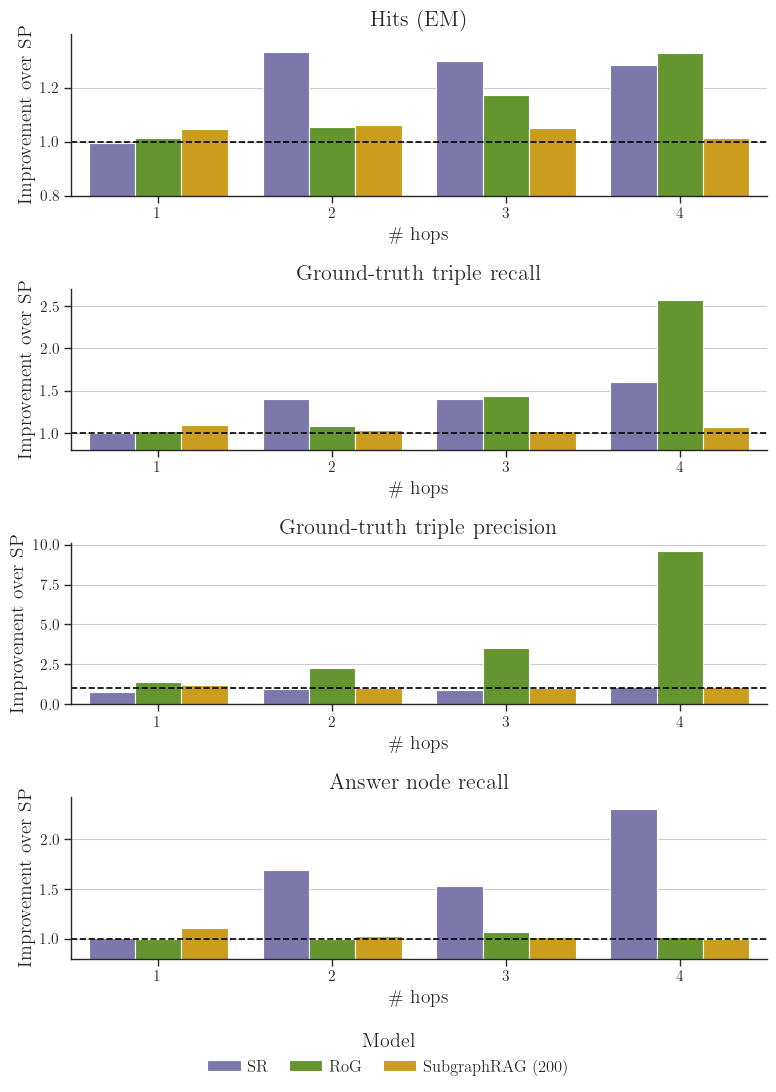

In [44]:
to_agg = "n_hops"
unique_vals = np.unique(stats_compared[to_agg].values)
stats = ["graphrag_hits", "gt_triple_recall", "gt_triple_precision", "ans_recall"]

fig, axn = plt.subplots(
    len(stats),
    1,
    figsize=(8, 2.6 * len(stats)),
)

mod_sorted = ["SR", "RoG", "SubgraphRAG (200)"]

for j, stat in enumerate(stats):
    ax = axn[j]

    sns.barplot(
        x="n_hops",
        y=stat + "_boost",
        hue="model",
        hue_order=mod_sorted,
        data=stats_compared.query("model != 'GCR'"),
        ax=ax,
        palette=[plot_utils.PALETTE[2], plot_utils.PALETTE[4], plot_utils.PALETTE[5]],
    )
    ax.set_xlabel("\# hops")
    ax.get_legend().remove()
    if j != 2:
        ax.set_ylim(0.8)
    ax.axhline(1.0, ls="--", color="k")
    ax.set_title(
        {
            "graphrag_hits": "Hits (EM)",
            "gt_triple_recall": "Ground-truth triple recall",
            "gt_triple_precision": "Ground-truth triple precision",
            "ans_recall": "Answer node recall",
        }[stat],
        fontsize=16,
    )
    ax.set_ylabel("Improvement over SP")
    ax.grid(axis="y")

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title="Model",
    bbox_to_anchor=(0.0, -0.06, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    columnspacing=1.25,
    handletextpad=0.4,
    fontsize=12,
)
plot_utils.tidy(ax.figure)

### SubgraphRAG n_triples sweep

In [45]:
all_data = {
    "_gt1": test_def_subgraphrag_res,
    "_gt2": test_def_subgraphrag_res2,
    "_gt3": test_def_subgraphrag_res3,
    "_sp1": test_def_subgraphrag_sp_res,
    "_sp2": test_def_subgraphrag_sp_res2,
    "_sp3": test_def_subgraphrag_sp_res3,
}

data_processed_gt = []
data_processed_sp = []
for name, data in all_data.items():
    sweep_res = []
    for i, dp in enumerate(data):
        gt_triples = np.array(
            [
                [rev_lkp_ent[h], rev_lkp_rel[r], rev_lkp_ent[t]]
                for h, r, t in test_ds[id_to_i[dp["id"]]][
                    "full_answer_subgraph_wikikg2"
                ]
            ]
        )
        ks = [int(k.split("_")[-1]) for k in dp.keys() if f"graphrag_answer" in k]
        ans_ids = [
            rev_lkp_ent.get(x, -1)
            for x in test_ds[id_to_i[dp["id"]]]["all_answers_wikikg2"]
        ]
        ans_ids = np.array([x for x in ans_ids if x != -1])
        answers_labels = [node_labels[x] for x in ans_ids]
        for k in ks:
            retr_triples = np.array(dp["graphrag_subgraph"])[:k]
            n_retr_triples = len(retr_triples)
            if len(retr_triples) == 0:
                retr_triples = np.array([[-1, -1, -1]])

            triple_hits = (
                (retr_triples[None, :, :] == gt_triples[:, None, :])
                .all(axis=-1)
                .any(1)
                .sum()
            )
            triple_recall = triple_hits / gt_triples.shape[0]
            triple_precision = triple_hits / n_retr_triples
            if triple_precision + triple_recall == 0.0:
                triple_f1_score = 0.0
            else:
                triple_f1_score = (
                    2
                    * triple_precision
                    * triple_recall
                    / (triple_precision + triple_recall)
                )

            ans_present = [x for x in ans_ids if x in retr_triples[:, [0, 2]]]
            ans_recall = (
                (retr_triples[:, [0, 2]].reshape(-1)[None, :] == ans_ids[:, None])
            ).any(axis=-1).sum() / len(answers_labels)

            ans_stats = {
                f"n_retr_triples": n_retr_triples,
                f"gt_triple_recall": 100 * triple_recall,
                f"gt_triple_precision": 100 * triple_precision,
                f"gt_triple_f1": 100 * triple_f1_score,
                f"ans_hits": 100 * (len(ans_present) > 0),
                f"ans_recall": 100 * ans_recall,
            }

            graphrag_em = exact_match(dp[f"graphrag_answer_{k}"], answers_labels)

            test_type = test_ds[id_to_i[dp["id"]]]["test_type"]
            an_res = {
                "id": dp["id"],
                "question": dp["question"],
                "n_hops": dp["n_hops"],
                "graph_template": test_ds[id_to_i[dp["id"]]]["graph_isomorphism"],
                "k": k,
                "n_seeds": len(dp["seed_nodes_id"]),
                "graphrag_hits": 100 * any(graphrag_em),
                "graphrag_recall": 100 * np.mean(graphrag_em).item(),
            }
            an_res.update(ans_stats)
            sweep_res.append(an_res)
    sweep_res = pd.DataFrame(sweep_res)
    if "gt" in name:
        data_processed_gt.append(sweep_res)
    else:
        data_processed_sp.append(sweep_res)

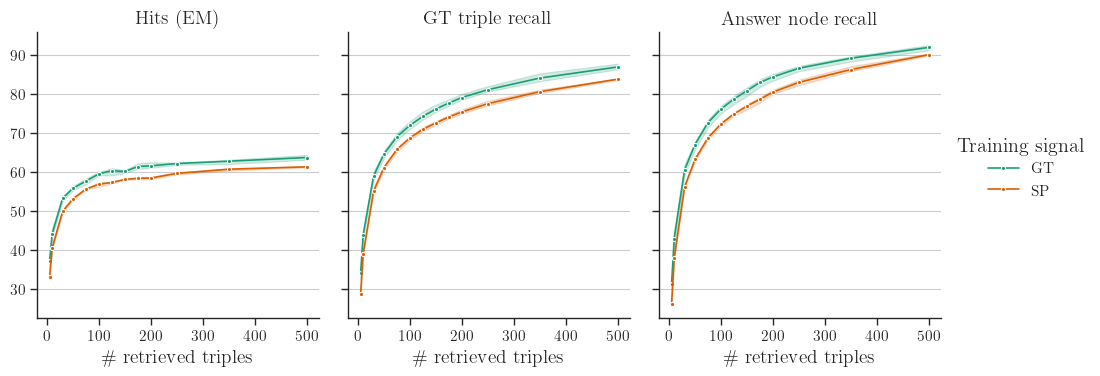

In [46]:
to_plot_gt = []
to_plot_sp = []
for data in data_processed_gt:
    data_grouped = data.groupby("k", as_index=False)[
        ["graphrag_hits", "gt_triple_recall", "gt_triple_precision", "ans_recall"]
    ].mean()
    to_plot_gt.append(data_grouped)

for data in data_processed_sp:
    data_grouped = data.groupby("k", as_index=False)[
        ["graphrag_hits", "gt_triple_recall", "gt_triple_precision", "ans_recall"]
    ].mean()
    to_plot_sp.append(data_grouped)

to_plot_gt = pd.concat(to_plot_gt, axis=0)
to_plot_sp = pd.concat(to_plot_sp, axis=0)

stats = {
    "graphrag_hits": "Hits (EM)",
    "gt_triple_recall": "GT triple recall",
    "ans_recall": "Answer node recall",
}
fig, axn = plt.subplots(1, 3, figsize=(11, 4), sharey=True)
for (stat, stat_name), ax in zip(stats.items(), axn.flatten()):
    sns.lineplot(to_plot_gt, x="k", y=stat, ax=ax, marker="o", label="GT")
    sns.lineplot(
        to_plot_sp,
        x="k",
        y=stat,
        ax=ax,
        marker="o",
        label="SP",
    )

    ax.set_ylabel("")
    ax.grid(axis="y")
    ax.set_xlabel("\# retrieved triples")
    ax.legend_.remove()
    ax.set_title(stat_name, fontsize=14)

plot_utils.set_figure_legend(
    ax.figure,
    *ax.get_legend_handles_labels(),
    title="Training signal",
)
plot_utils.tidy(ax.figure)